In [1]:
import pandas as pd
import numpy as np
import pickle
from collections import defaultdict
from collections import Counter
import math
import tqdm
import ast

In [2]:
#saving dict function
def save_dict(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

#load dict function
def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

## Naïve Bayes: Multinomial Event Model

In [3]:
train = pd.read_csv('mapped_dataset.csv')  #to read

#to maintain the list format
train['mapped_text'] = train['mapped_text'].map(ast.literal_eval)
train.drop({'Unnamed: 0'},axis=1,inplace=True)

In [4]:
train.head()

,id,text,label,mapped_text
0,30346,nobel laureate say trump policy may lead budge...,0,"[79910, 43802, 28875, 54182, 10144, 32671, 215..."
1,33007,bet trump win north korea h bomb prediction si...,0,"[5735, 54182, 28918, 25509, 88797, 43564, 6458..."
2,16912,obama communist environmental arm tell kid red...,1,"[59591, 9270, 413, 20026, 11421, 65944, 38687,..."
3,24392,house tax panel chair corporate tax cut may ta...,0,"[25988, 32797, 53901, 87028, 61368, 32797, 306..."
4,21239,british tv personality blame trump muslim ban ...,1,"[21131, 49545, 22005, 4321, 54182, 47472, 4043..."


In [5]:
train_0 = train.loc[train['label']==0]
train_1 = train.loc[train['label']==1]

In [6]:
word_index = load_obj('word_index')

### Parameters

In [7]:
phi_y_1 = train['label'].sum()/len(train)
phi_y_0 = 1 - phi_y_1

In [8]:
# Class priors
phi_y_1 = train['label'].sum()/len(train)
phi_y_0 = 1 - phi_y_1

# Conditionals 
n = len(word_index)

phi_0 = np.ones(n) 
phi_1 = np.ones(n)

d_0 = sum([len(i) for i in train_0.mapped_text])
d_1 = sum([len(i) for i in train_1.mapped_text])

for word, value in word_index.items():
    for tup in value:
        if tup[2] == 0:
            phi_0[word] += tup[1]
        else:
            phi_1[word] += tup[1]
            
phi_0 = phi_0/(d_0+n)
phi_1 = phi_1/(d_1+n)

In [9]:
phi_1[0:25]

array([2.11025224e-07, 4.22050448e-07, 4.22050448e-07, 4.22050448e-07,
       2.11025224e-07, 6.33075672e-07, 1.26615134e-06, 2.11025224e-07,
       8.65203418e-06, 2.11025224e-07, 6.33075672e-07, 1.89922701e-06,
       2.11025224e-07, 2.11025224e-07, 4.22050448e-07, 4.22050448e-07,
       2.11025224e-07, 2.11025224e-07, 1.13320545e-04, 4.22050448e-07,
       1.56158666e-05, 8.44100895e-07, 1.28725387e-05, 4.22050448e-07,
       4.22050448e-07])

In [10]:
phi_0[0:25]

array([4.78896125e-07, 2.39448063e-07, 2.39448063e-07, 2.39448063e-07,
       4.78896125e-07, 2.39448063e-07, 2.39448063e-07, 7.18344188e-07,
       3.83116900e-06, 4.78896125e-07, 2.39448063e-07, 7.18344188e-07,
       9.57792251e-07, 1.19724031e-06, 2.39448063e-07, 2.39448063e-07,
       4.78896125e-07, 4.78896125e-07, 3.20860404e-05, 2.39448063e-07,
       2.15503256e-06, 2.39448063e-07, 9.81737057e-06, 2.39448063e-07,
       4.78896125e-07])

## Testing

In [11]:
test = pd.read_csv('test.csv')
test.rename(columns={'Unnamed: 0': 'id'}, inplace=True) 
test.head()

In [13]:
vocabulary = load_obj('vocabulary')

In [14]:
def mapping_2(text):
    text = text.split()
    out = [vocabulary[word] if word in vocabulary.keys() else word for word in text]
    return out

In [15]:
test['mapped_text'] = test.text.apply(lambda x: mapping_2(x))
test.head()

In [17]:
def predict(mapped_text):
    
    phi_0_test = np.log(phi_y_0)
    phi_1_test = np.log(phi_y_1)
    
    for word in mapped_text:
        if type(word) == type('str'):
            phi_0_test += np.log(1/(d_0+n))
            phi_1_test += np.log(1/(d_1+n))
        else:
            phi_0_test += np.log(phi_0[word])
            phi_1_test += np.log(phi_1[word])
            
    if phi_0_test > phi_1_test:
        return 0
    return 1

#### Prediction over Test Set

In [18]:
test['predict'] = test.mapped_text.apply(lambda x: predict(x))

In [33]:
test

,id,text,label,mapped_text,predict
0,3,trump ob even obama name cod website image chr...,1,"[54182, 66257, 41368, 59591, 62928, 65455, 118...",1
1,13,watch lindsey graham trash medium portray trum...,1,"[26996, 57148, 81522, 38776, 88853, 750, 54182...",1
2,24,white house sexist trump slut shame sen kirste...,1,"[36853, 25988, 85201, 54182, 40361, 88105, 652...",1
3,25,despicable trump suggest female senator would ...,1,"[69784, 54182, 67885, 14045, 9059, 19854, 7146...",1
4,31,watch proof trump unfit service new question a...,1,"[26996, 86600, 54182, 45450, 47423, 5944, 3730...",1
...,...,...,...,...,...
8975,44882,argentina labor union protest job loss macri p...,0,"[2536, 83645, 31429, 501, 56884, 73374, 8488, ...",0
8976,44885,exclusive u withhold million egypt aid washing...,0,"[31655, 76408, 39678, 71336, 39139, 46678, 881...",0
8977,44890,u north korea clash u n arm forum nuclear thre...,0,"[76408, 25509, 88797, 51303, 76408, 11621, 200...",0
8978,44891,headless torso could belong submarine journali...,0,"[11363, 66650, 82571, 12015, 72084, 32767, 882...",0


In [34]:
test.loc[test['label']!=test['predict']]

,id,text,label,mapped_text,predict
84,404,two florida lawmaker vote hurricane relief irm...,1,"[77333, 31414, 12763, 45099, 47267, 37998, 869...",0
184,881,world leader decide need u move forward climat...,1,"[31477, 3821, 53922, 72661, 76408, 20276, 3997...",0
258,1261,trump take another major step toward u longer ...,1,"[54182, 15503, 18423, 8298, 56890, 14384, 7640...",0
277,1371,already happen dapl spew oil multiple leak con...,1,"[72597, 44821, 73180, 70400, 80572, 38463, 868...",0
291,1433,putin claim transcript white house meet availa...,1,"[66710, 49441, 17081, 36853, 25988, 86831, 696...",0
...,...,...,...,...,...
8566,42876,australian police charge man attack former pm ...,0,"[77213, 58414, 18667, 52381, 51687, 80700, 330...",1
8712,43692,uk police release new image jogger london bus ...,0,"[85998, 58414, 19837, 5944, 56339, 2042, 30103...",1
8772,43948,irma evacuee find full hotel warm welcome geor...,0,"[86930, 327, 8014, 28192, 62756, 43399, 81186,...",1
8784,44014,manchester concert venue shatter bomb attack r...,0,"[39088, 28324, 60727, 37133, 64583, 51687, 611...",1


In [231]:
err = round((1-(test.loc[test['label']!=test['predict']].shape[0]/test.shape[0]))*100,2)
print('Accuracy:', str(err) + '%')

Accuracy: 96.37%


#### Prediction over Train Set

In [36]:
train['predict'] = train.mapped_text.apply(lambda x: predict(x))

In [37]:
train.loc[train['label']!=train['predict']]

,id,text,label,mapped_text,predict
14,32999,boston men jail trump inspire hate crime attac...,0,"[40422, 16555, 86482, 54182, 316, 65927, 43479...",1
52,33318,u capitol replace flag display confederate ima...,0,"[76408, 30891, 5294, 35714, 39391, 69333, 1445...",1
62,20368,iceland stun election anti establishment polit...,1,"[80843, 82841, 74567, 45424, 80096, 3606, 8621...",0
66,1787,break trump play fire bring u one step closer ...,1,"[30984, 54182, 10943, 18564, 7379, 76408, 7751...",0
67,17484,obama corrupt inner circle desperately fight p...,1,"[59591, 47066, 43861, 59521, 69628, 20239, 366...",0
...,...,...,...,...,...
35871,21043,germany angela merkel make incredibly naive an...,1,"[37492, 9074, 31647, 76362, 42341, 9887, 5929,...",0
35873,31028,trump hustle stage nevada security agent reno ...,0,"[54182, 64980, 86269, 74561, 11645, 32395, 339...",1
35896,25602,trump blast republican senator moral equivalen...,0,"[54182, 24086, 84149, 9059, 13030, 79821, 2096...",1
35906,32127,democrat disarray eve convention nominate clin...,0,"[64917, 34908, 34022, 10526, 44390, 71, 64605,...",1


In [230]:
err = round((1-(train.loc[train['label']!=train['predict']].shape[0]/train.shape[0]))*100,2)
print('Accuracy:', str(err) + '%')

Accuracy: 96.52%


### Confusion Matrix

In [232]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt   

In [49]:
y_true = test.label
y_predicted = test.predict
df_confusion = confusion_matrix(y_true, y_predicted)
df_confusion

array([[4027,  213],
       [ 200, 4540]])

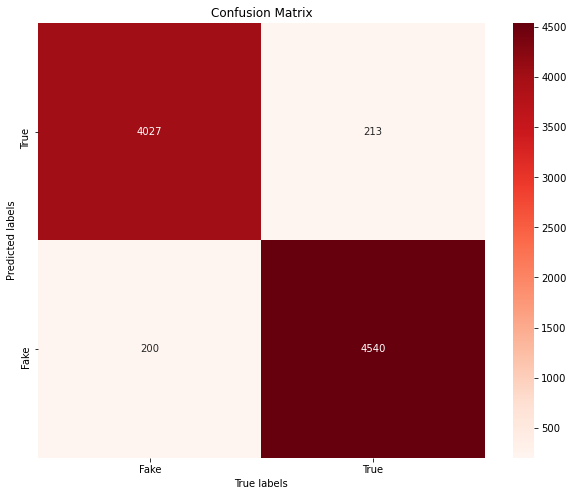

In [107]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(df_confusion, annot=True, fmt = 'd', ax = ax, cmap = 'Reds'); 

ax.set_xlabel('True labels');ax.set_ylabel('Predicted labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Fake', 'True']); ax.yaxis.set_ticklabels(['True', 'Fake']);

## Naïve Bayes: Multivariate Bernoulli

In [211]:
train = pd.read_csv('train.csv')
train.rename(columns={'Unnamed: 0': 'id'}, inplace=True) 
train.head()

,id,text,label
0,30346,nobel laureate say trump policy may lead budge...,0
1,33007,bet trump win north korea h bomb prediction si...,0
2,16912,obama communist environmental arm tell kid red...,1
3,24392,house tax panel chair corporate tax cut may ta...,0
4,21239,british tv personality blame trump muslim ban ...,1


In [212]:
test = pd.read_csv('test.csv')
test.rename(columns={'Unnamed: 0': 'id'}, inplace=True) 
test.head()

,id,text,label
0,3,trump ob even obama name cod website image chr...,1
1,13,watch lindsey graham trash medium portray trum...,1
2,24,white house sexist trump slut shame sen kirste...,1
3,25,despicable trump suggest female senator would ...,1
4,31,watch proof trump unfit service new question a...,1


In [213]:
train_0 = train.loc[train['label']==0]
train_1 = train.loc[train['label']==1]

### Definition of parameters

In [ ]:
phi_y_1 = train['label'].sum()/len(train)
phi_y_0 = 1 - phi_y_1

In [214]:
def zeros():
    return 0

d_1 = defaultdict(zeros)
d_0 = defaultdict(zeros)

In [ ]:
def create_dict(text,d,length):
    for word in set(text.split()):
        d[word]+=1/(length + 2)

In [215]:
train_0.text.apply(lambda x: create_dict(x,d_0,len(train_0)))
phi_0 = d_0

In [216]:
train_1.text.apply(lambda x: create_dict(x,d_1,len(train_1)))
phi_1 = d_1

### Testing

In [217]:
def predict(text):
    
    phi_0_test = np.log(phi_y_0)
    phi_1_test = np.log(phi_y_1)
    

    for word in set(text.split()):
        if word in d_0.keys():
            phi_0_test += np.log(phi_0[word])
        else:
            phi_0_test += np.log(1/(len(train_0)+2))
            
        if word in d_1.keys():
            phi_1_test += np.log(phi_1[word])
        else:   
            phi_1_test += np.log(1/(len(train_1)+2)) 
                
    if phi_0_test > phi_1_test:
        return 0
    return 1

#### Prediction over Test Set

In [218]:
test['predict'] = test.text.apply(lambda x: predict(x))

In [220]:
test.loc[test['label']!=test['predict']]

,id,text,label,predict
184,881,world leader decide need u move forward climat...,1,0
258,1261,trump take another major step toward u longer ...,1,0
392,1927,report trump cost america billion tourism reve...,1,0
1864,9092,trump end free money train pakistan refuse sto...,1,0
1872,9113,israel name new train station near western wal...,1,0
...,...,...,...,...
8712,43692,uk police release new image jogger london bus ...,0,1
8718,43738,mexican town woman muxes take charge massive q...,0,1
8772,43948,irma evacuee find full hotel warm welcome geor...,0,1
8784,44014,manchester concert venue shatter bomb attack r...,0,1


In [229]:
err = round((1-(test.loc[test['label']!=test['predict']].shape[0]/test.shape[0]))*100,2)
print('Accuracy:', str(err) + '%')

Accuracy: 96.37%


#### Prediction over train set

In [222]:
train['predict'] = train.text.apply(lambda x: predict(x))

In [223]:
train.loc[train['label']!=train['predict']]

,id,text,label,predict
7,21783,controversy christian flag engulf small town l...,1,0
14,32999,boston men jail trump inspire hate crime attac...,0,1
62,20368,iceland stun election anti establishment polit...,1,0
67,17484,obama corrupt inner circle desperately fight p...,1,0
78,32237,protester keep kid away cleveland republican c...,0,1
...,...,...,...,...
35786,24667,nfl policy anthem kneel unchanged despite trum...,0,1
35841,16764,alert flood cuban breeze across texas border t...,1,0
35871,21043,germany angela merkel make incredibly naive an...,1,0
35873,31028,trump hustle stage nevada security agent reno ...,0,1


In [228]:
err = round((1-(train.loc[train['label']!=train['predict']].shape[0]/train.shape[0]))*100,2)
print('Accuracy:', str(err) + '%')

Accuracy: 96.52%


### Confusion Matrix

In [233]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt   

In [200]:
y_true = test.label
y_predicted = test.predict
df_confusion = confusion_matrix(y_true, y_predicted)
df_confusion

array([[4031,  209],
       [ 117, 4623]])

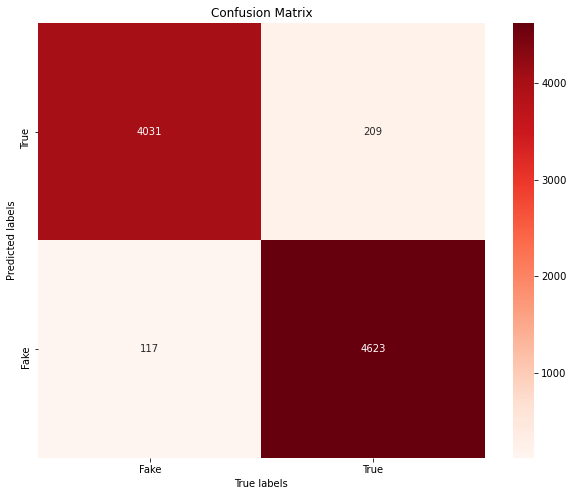

In [202]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(df_confusion, annot=True, fmt = 'd', ax = ax, cmap = 'Reds'); 

ax.set_xlabel('True labels');ax.set_ylabel('Predicted labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Fake', 'True']); ax.yaxis.set_ticklabels(['True', 'Fake']);